## Makemore 2 - Exercises

## Exercise 1 - Beating the Game

**Objective:** Tune the hyperparameters of the training to beat Andrej's best validation loss of $2.2$.<br>

In [1]:
import tqdm
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

In [3]:
words = open("names.txt", "r").read().splitlines() # Python list of strings
print(words[:8]) # show a sample of the first 8 names
print(len(words)) # this many words in total

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [4]:
# build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words)))) # set(): Throwing out letter duplicates
stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0 # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()} # Switch order of (char, counter) to (counter, char)

In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182625, 3]) 	Y: torch.Size([182625])
Validation Set:
X: torch.Size([22655, 3]) 	Y: torch.Size([22655])
Test Set:
X: torch.Size([22866, 3]) 	Y: torch.Size([22866])


In [6]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((block_size * 20, 200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

18167 parameters


In [7]:
epochs = 400_000

for i in tqdm.tqdm(range(epochs)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128

    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)

    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    if i < 0.1 * epochs:
      lr = 0.3
    elif i < 0.2 * epochs:
      lr = 0.1
    elif i < 0.4 * epochs:
      lr = 0.06
    else:
      lr = 0.03

    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

# print('Loss for current mini-batch:', loss.item())

100%|██████████| 400000/400000 [02:44<00:00, 2434.74it/s]


In [8]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1257266998291016


## Exercise 2 - Weight Initialization

**Objective:** I was not careful with the intialization of the network in this video.<br>
**(1)** What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?<br>
**(2)** Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [9]:
scaling_factor = 0.01
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g) * scaling_factor
W1 = torch.randn((block_size * 20, 200), generator=g) * scaling_factor
b1 = torch.zeros((200))
W2 = torch.randn((200, 27), generator=g) * scaling_factor
b2 = torch.zeros((27))  # Zero biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

18167 parameters


In [10]:
epochs = 400_000

for i in tqdm.tqdm(range(epochs)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128

    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)

    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    if i < 0.1 * epochs:
      lr = 0.3
    elif i < 0.2 * epochs:
      lr = 0.1
    elif i < 0.4 * epochs:
      lr = 0.06
    else:
      lr = 0.03

    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

100%|██████████| 400000/400000 [03:10<00:00, 2096.93it/s]


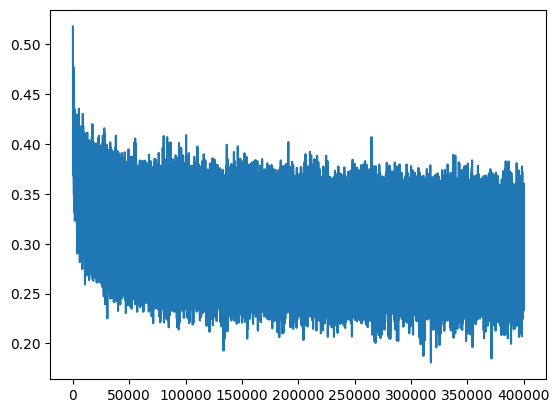

In [11]:
plt.plot(stepi, lossi);

In [12]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.0974793434143066


## Exercise 3 - A Neural Probabilistic Language Model (Bengio et al. 2003)
**Objective:** Read the [Bengio et al 2003 paper](https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), implement and try any idea from the paper. Did it work?

In [13]:
scaling_factor = 0.01

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g) * scaling_factor
W1 = torch.randn((block_size * 20, 200), generator=g) * scaling_factor
b1 = torch.zeros((200))
W2 = torch.randn((200, 27), generator=g) * scaling_factor
b2 = torch.zeros((27))  # Zero biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

18167 parameters


In [14]:
epochs = 400_000
weight_decay = 1e-5

emb_params = [C]
nn_params = [W1, b1, W2, b2]

for i in tqdm.tqdm(range(epochs)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 256

    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)

    # Loss with decayed l2 regularization term added
    # L2 represents here what the (kind of ambivalent) regularization term R(θ) is in the paper
    l2 = sum((p ** 2.0).sum() for p in parameters)
    loss = F.cross_entropy(logits, Ytr[ix]) + weight_decay * l2

    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Different layers get different lr treatments
    if i < 0.2 * epochs:
        lr_emb, lr_nn = 0.1, 0.3
    elif i < 0.3 * epochs:
        lr_emb, lr_nn = 0.05, 0.1
    elif i < 0.5 * epochs:
        lr_emb, lr_nn = 0.03, 0.06
    else:
        lr_emb, lr_nn = 0.01, 0.03

    # Update and decay weights of different layers
    for p in emb_params:
        p.data += -lr_emb * (p.grad + weight_decay * p)
    for p in nn_params:
        p.data += -lr_nn * (p.grad + weight_decay * p)

    stepi.append(i)
    lossi.append(loss.log10().item())

100%|██████████| 400000/400000 [05:19<00:00, 1250.04it/s]


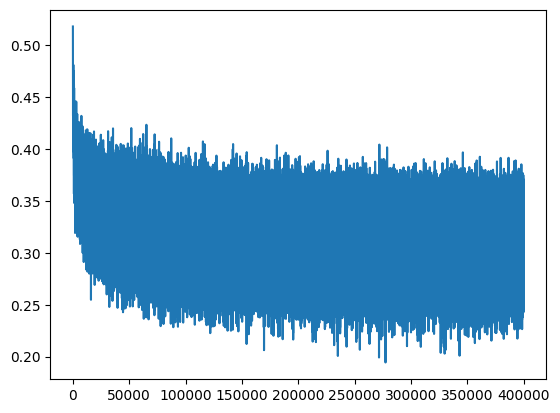

In [15]:
plt.plot(stepi, lossi);

In [16]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 20) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.0903823375701904
